<a href="https://colab.research.google.com/github/rahul-jha98/zomato_sales_visualizer/blob/master/DM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create CSV

In [0]:
import json
import requests
from tqdm.notebook import tqdm

In [0]:
city_name = "Allahabad"

In [0]:
class Restaurant:
    def __init__(self, restaurant_json):
        self.restaurant_json = restaurant_json
        self.prepare_prameters_from_json()
    
    
    def get(self, value, json = ''):
        if json == '':
            json = self.restaurant_json
            
        if json == None:
            return None
        
        return json.get(value, None)

    def prepare_prameters_from_json(self):
        self.id = self.get('id')
        self.name = self.get('name')
        self.url = self.get('url')
        
        location = self.get('location')
        self.address = self.get('address', location)
        self.latitude = self.get('latitude', location)
        self.longitude = self.get('longitude', location)
        self.location = self.get('locality', location)
        self.city = self.get('locality', location)
        
        
        self.online_order = 'Yes' if self.get('has_online_delivery') == 1 else 'No'
        self.book_table = 'Yes' if self.get('has_table_booking') == 1 else 'No'
        
        
        rating = self.get('aggregate_rating', self.get('user_rating'))
        
        if rating == None or rating == "NEW":
            self.rate = rating
        else:
            self.rate = '{}/5'.format(rating)
        
        self.votes = self.get('votes', self.get('user_rating'))
        
        phone = self.get('phone_numbers')
        if sum(c.isdigit() for c in phone) < 10:
            self.phone = None
        else:
            self.phone = phone
        
        self.rest_type = ', '.join(self.get('establishment'))
        
        self.cuisines = self.get('cuisines')
        
        self.approx_cost = self.get('average_cost_for_two')
        
        self.dish_liked = ''
        
        self.reviews = []


        
    def set_reviews(self, reviews):
        self.reviews = reviews


    
    def set_dish_liked(self, dish_liked):
        self.dish_liked = dish_liked

        
    
    def __str__(self):
        basic =  "ID : {0}\nName: {1}\nURL: {2}\n\n".format(self.id, self.name, self.url)
        
        location = "Address : {0}\nLatitude : {1}\nLongitue : {2}\nLocation : {3}\n\n".format(self.address,
                                                                                             self.latitude,
                                                                                             self.longitude,
                                                                                             self.location)
        
        online = "Online : {0}\nBooking : {1}\nRating : {2}\nVotes : {3}\nPhone: {4}\n\n".format(self.online_order,
                                                                                            self.book_table,
                                                                                            self.rate,
                                                                                            self.votes,
                                                                                            self.phone)
        other = "Approx Cost: {0}\nCusines: {1}\nRestaurant Type: {2}\nDish Liked: {3}\n".format(self.approx_cost,
                                                                             self.cuisines,
                                                                             self.rest_type,
                                                                             self.dish_liked)
        
        reviews = "Reviews {}".format(self.reviews)
        
        return basic + location + online + other + reviews

    def get_row(self):
      
      return [self.url, self.address, self.name, self.online_order, self.book_table, self.rate, self.votes,
              self.phone, self.location, self.rest_type, self.dish_liked, self.cuisines, self.approx_cost, 
              self.reviews, self.latitude, self.longitude, self.location]


In [0]:
class ZomatoDatasetCreator:
    def __init__(self, city_name):
        
        # self.API_KEYS = ["1c1827e986cbb720c34bc661fdbd8884", 
        #                  "765fdb97e275ccf353c49c3c2ec68a7b",
        #                  "151799c34aa8943e8028a167e43f9588"]

        ## Abhi naya bana ke do daal do isme kal purana wala bhi append kar dena list me
        ## Basically ek city ke liye around 1500 calls hote hai so 
        self.API_KEYS = ["014af0114a43afec41812542b307726b", 
                         ]               
        self.BASE_URL = "https://developers.zomato.com/api/v2.1/"
        
        self.api_count = 0
        self.api_len = len(self.API_KEYS)
        
        self.city_name = city_name
    
    def get_response(self, end_point, query_params_dict):    
        url = self.BASE_URL + end_point
        
        self.api_count = (self.api_count + 1) % self.api_len
        
        return requests.get(url, 
                    params = query_params_dict,
                    headers = {'user-key':self.API_KEYS[self.api_count]}) 
    
    
    def search_city(self):
        response = self.get_response('locations', {'query': self.city_name})

        if response:
            result = response.json()['location_suggestions']

            if len(result) == 0:
                raise Exception("Search result is empty.")
            else:

                self.city_name = result[0]['city_name']
                self.city_id = result[0]['city_id']
                print("Setting the city name to ", self.city_name)
        else:
            raise Exception("Network Error")
            
            
            
    
    def fetch_establishments_dictionary(self):
        response = self.get_response('establishments', {'city_id': self.city_id})

        all_establishments = response.json()['establishments']

        estabishment_dict = {}

        for establishment in all_establishments:
            establishment = establishment['establishment']
            key, value = establishment.values()

            if type(value) == str:
                estabishment_dict[key] = value
            else:
                establishment_dict[value] = key

        return estabishment_dict
    
    
    
    
    
    
    def fetch_all_restaurants(self):
        
        self.all_restaurant_ids = {}

        establishments = self.fetch_establishments_dictionary()

        self.all_restaurants = []
        for sort_param in ['cost', 'rating']:
            self.sort_param = sort_param
            print('\n' + self.sort_param)
            for e_id in establishments.keys():
                print('\n' + establishments[e_id])
                self.fetch_restaurants_of_type(e_id)    
                
                
                
                
    def fetch_restaurants_of_type(self, establishment_id, offset = 0, 
                                sort_order = 'desc', count = 20, max_pages = 5):
    
        if offset == max_pages:
            return

        response = self.get_response('search', {'entity_id': self.city_id, 'entity_type': 'city',
                                           'establishment_type': establishment_id,
                                           'sort': self.sort_param,
                                           'order':sort_order,
                                          'start': offset * 20,
                                          'count':count})

        if response:
            result = response.json()
            queried = result['results_start'] + result['results_shown']
            print(queried, end = ' ')
            total = result['results_found']
            count -= result['results_shown']


            restaurants_json = result['restaurants']

            for restaurant in restaurants_json:
                if self.all_restaurant_ids.get(restaurant['restaurant']['id'], -1) == -1:
                    self.all_restaurant_ids[restaurant['restaurant']['id']] = 0
                    self.all_restaurants.append(Restaurant(restaurant['restaurant']))


            if total > queried and sort_order == 'desc': 
                if offset + 1 < max_pages:
                    self.fetch_restaurants_of_type(establishment_id, offset + 1)
                else:
                    left = total - queried
                    self.fetch_restaurants_of_type(establishment_id, 0, 'asc', left)

            elif total > queried: 
                self.fetch_restaurants_of_type(establishment_id, offset + 1, 'asc', count)
            
        else:
            return None
        
        
    def fetch_reviews(self, res_id):
        response = self.get_response('reviews', 
                         {'res_id': res_id})
        
        reviews = []
        if response:
            response = response.json()
            fetched_reviews = response['user_reviews']
            
            for review in fetched_reviews:
                rating = 'Rated {}'.format(review['review']['rating'])
                text = review['review']['review_text']
                reviews.append((rating, text))
            
            return reviews
        else:
            return []
        
    
    def populate_reviews(self):
        for restaurant in tqdm(self.all_restaurants):
            restaurant.set_reviews(self.fetch_reviews(restaurant.id))
            
    def populate_dish_liked(self):
        
        def find_nth_occurance(string, char, n):
            val = -1
            for i in range(n):
                val = string.find(char, val + 1)
            return val
        

        for restaurant in tqdm(self.all_restaurants):
            
            URL = restaurant.url

            headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}
            response = requests.get(URL.split('?')[0],headers=headers)     

            html = response.text

            pos = html.find('Top Dishes People Order')
            if  pos!= -1:
                remaining = html[pos:]
                start = find_nth_occurance(remaining, '>', 2)
                end = find_nth_occurance(remaining, '<', 3)
                restaurant.set_dish_liked(remaining[start + 1:end])

In [0]:
data_creator = ZomatoDatasetCreator(city_name)

In [7]:
data_creator.search_city()

Setting the city name to  Allahabad


In [8]:
data_creator.fetch_all_restaurants()


cost

Casual Dining
20 40 60 80 100 20 40 60 80 100 
Sweet Shop
20 40 60 80 86 
Quick Bites
20 40 60 80 100 20 40 60 80 100 
Fine Dining
2 
Bhojanalya
14 
Bar
9 
Dessert Parlour
20 40 60 65 
Café
20 40 45 
Dhaba
20 23 
Kiosk
13 
Bakery
20 33 
Lounge
8 
Beverage Shop
20 24 
Butcher Shop
2 
Food Court
7 
Food Truck
5 
Paan Shop
4 
Confectionery
1 
General Store
0 
Microbrewery
0 
rating

Casual Dining
20 40 60 80 100 20 40 60 80 100 
Sweet Shop
20 40 60 80 86 
Quick Bites
20 40 60 80 100 20 40 60 80 100 
Fine Dining
2 
Bhojanalya
14 
Bar
9 
Dessert Parlour
20 40 60 65 
Café
20 40 45 
Dhaba
20 23 
Kiosk
13 
Bakery
20 33 
Lounge
8 
Beverage Shop
20 24 
Butcher Shop
2 
Food Court
7 
Food Truck
5 
Paan Shop
4 
Confectionery
1 
General Store
0 
Microbrewery
0 

In [9]:
data_creator.populate_reviews()

In [0]:
# data_creator.populate_dish_liked()

In [0]:
data_list = data_creator.all_restaurants

## Flask Server


In [12]:
from flask import Flask, abort, jsonify, request, render_template,Response
from flask_ngrok import run_with_ngrok
import numpy as np
import pandas as pd
import json


app = Flask(__name__)
run_with_ngrok(app)

@app.route('/')
def home():
    return "surprise mother fucker"

@app.route('/api/', methods = ['POST'])

def api():
    
    json_data = request.json
    city_name = json_data['city_name']
    print("Recieved City: ", city_name)
    
    data_creator = ZomatoDatasetCreator(city_name)
    city_found = data_creator.search_city()
    
    if city_found != None:
        return Response(json.dumps({"status":1, "city_name": city_name}))
    
    return Response(json.dumps({"status":0, "city_name": None}))

if __name__=='__main__':
    app.run()

ModuleNotFoundError: ignored

**Fetch data to CSV**

In [0]:
import numpy as np
import pandas as pd

In [14]:
np_data  = np.empty((len(data_list), len(data_list[0].get_row())), dtype=object)
for i in tqdm(range(len(data_list[:]))):
  rest = data_list[i]
  np_data[i] = rest.get_row()

In [15]:
np_data

array([['https://www.zomato.com/allahabad/rang-mahal-hotel-ajay-international-civil-lines?utm_source=api_basic_user&utm_medium=api&utm_campaign=v2.1',
        'A/2/D, Lal Bahadur Shastri Marg, Civil Lines, Allahabad',
        'Rang Mahal - Hotel Ajay International', ..., '25.4539306187',
        '81.8280544505', 'Civil Lines'],
       ['https://www.zomato.com/allahabad/bercos-4-civil-lines?utm_source=api_basic_user&utm_medium=api&utm_campaign=v2.1',
        '17C, 0-1, Stretchy Road, Civil Lines, Allahabad', "Berco's",
        ..., '25.4522500000', '81.8328900000', 'Civil Lines'],
       ['https://www.zomato.com/allahabad/fusion-bar-restaurant-civil-lines?utm_source=api_basic_user&utm_medium=api&utm_campaign=v2.1',
        '3C/7C, Clive Road, Opposite Sangam Place, Civil Lines, Allahabad',
        'Fusion Bar & Restaurant', ..., '0.0000000000', '0.0000000000',
        'Civil Lines'],
       ...,
       ['https://www.zomato.com/allahabad/taste-of-prayagraj-2-dhoomanganj?utm_source=api_ba

In [16]:
df = pd.DataFrame(np_data, columns = ['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes', 'phone', 'location',
                                      'rest_type', 'dish_liked', 'cuisines', 'approx_cost', 'reviews', 'latitude', 'longitude', 'location'])

df.head()

url  ...     location
0  https://www.zomato.com/allahabad/rang-mahal-ho...  ...  Civil Lines
1  https://www.zomato.com/allahabad/bercos-4-civi...  ...  Civil Lines
2  https://www.zomato.com/allahabad/fusion-bar-re...  ...  Civil Lines
3  https://www.zomato.com/allahabad/jannat-hotel-...  ...  Civil Lines
4  https://www.zomato.com/allahabad/barbeque-nati...  ...  George Town

[5 rows x 17 columns]

In [0]:
import os as os
os.mkdir(city_name)

In [0]:
df.to_csv(city_name+'/data.csv')

In [19]:
URL = "https://www.zomato.com/allahabad/goli-vada-pav-no-1-1-civil-lines?utm_source=api_basic_user&utm_medium=api&utm_campaign=v2.1"

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}
response = requests.get(URL.split('?')[0],headers=headers)    

KeyboardInterrupt: ignored

**Dataset Upload**

In [20]:
import numpy as np 
import pandas as pd
from tqdm.notebook import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=False)
from wordcloud import WordCloud
from geopy.geocoders import Nominatim
from folium.plugins import HeatMap
import folium
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from gensim.models import word2vec
import nltk

## Connecting To firebase

In [21]:
!pip install firebase
!pip install python_jwt
!pip install gcloud
!pip install sseclient
!pip install Crypto
!pip install pycryptodome
!pip install requests_toolbelt

     |████████████████████████████████| 81kB 2.6MB/s 
     |████████████████████████████████| 2.7MB 8.7MB/s 
     |████████████████████████████████| 460kB 2.7MB/s 
  Created wheel for gcloud: filename=gcloud-0.18.3-cp36-none-any.whl size=602937 sha256=a9f1025a46ca17da7fa7c2618ca87642e5ac2e8446725381d83762c6f5914662
  Stored in directory: /root/.cache/pip/wheels/b9/9b/9c/a01be401658fea33b93a35d03921b0c638266821b264dc8662
Successfully built gcloud
  Created wheel for sseclient: filename=sseclient-0.0.26-cp36-none-any.whl size=5526 sha256=fab07a1df21bfdc9c99ae21626cbf5399649b7574e9d33c252e0d68d4075bc2c
  Stored in directory: /root/.cache/pip/wheels/c1/6d/f7/721cf7fe8dfc2d3a6502886a4239fe6a56e9317ad2c87eb718
Successfully built sseclient
     |████████████████████████████████| 593kB 3.9MB/s 
     |████████████████████████████████| 13.7MB 233kB/s 
     |████████████████████████████████| 61kB 1.9MB/s 


In [0]:
from google.cloud import storage
from firebase import firebase
import os

import firebase_admin
from firebase_admin import credentials
from firebase_admin import storage

In [0]:
import base64

In [0]:
class ConnectFirebase():
    def __init__(self, cred_pth = '/content/firebase_admin_sdk.json', db_pth = 'https://zomato-4a45e.firebaseio.com/',storage_pth = 'zomato-4a45e.appspot.com'):
        # os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = cred_pth
        cred = credentials.Certificate(cred_pth)
        firebase_admin.initialize_app(cred, {
            'storageBucket': 'zomato-4a45e.appspot.com'
        })
        self.firebase = firebase.FirebaseApplication(db_pth)
        # self.client = storage.Client()
        self.bucket = storage.bucket()

    def push_image(self, img_pth, location, idx):
        # self.imageBlob = self.bucket.blob("/")
        # self.imageBlob.metadata = {}

        img_name = location+'/'+str(idx)+'.'+img_pth[-3:]
        self.imageBlob = self.bucket.blob(img_name)
        # self.imageBlob.upload_from_filename(img_pth)
        self.imageBlob.upload_from_string(
            base64.b64encode(open(img_pth, 'rb').read()),
            content_type='image/jpg'
        )
        return self.imageBlob.public_url

In [0]:
firebaseConnect = ConnectFirebase()

In [0]:
firebaseConnect.push_image('/content/test.png', 'Allahabad', 3)

'https://storage.googleapis.com/zomato-4a45e.appspot.com/Allahabad/3.png'

In [0]:
def create_dictionary(img_names, img_titles, img_descriptions, img_urls):
    dic = {}
    for name, idx in enumerate(img_names):
        dic[name] = {'name': img_titles[idx], 'longtext': img_descriptions[idx], 'url': img_urls[idx]}

    return dic

# Data Exploration

In [0]:
fig_dat = {}

In [77]:
df = pd.read_csv("./"+city_name+"/data.csv")
df.head()

Unnamed: 0  ...   location.1
0           0  ...  Civil Lines
1           1  ...  Civil Lines
2           2  ...  Civil Lines
3           3  ...  Civil Lines
4           4  ...  George Town

[5 rows x 18 columns]

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785 entries, 0 to 784
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    785 non-null    int64  
 1   url           785 non-null    object 
 2   address       785 non-null    object 
 3   name          785 non-null    object 
 4   online_order  785 non-null    object 
 5   book_table    785 non-null    object 
 6   rate          785 non-null    object 
 7   votes         785 non-null    int64  
 8   phone         707 non-null    object 
 9   location      785 non-null    object 
 10  rest_type     785 non-null    object 
 11  dish_liked    0 non-null      float64
 12  cuisines      785 non-null    object 
 13  approx_cost   785 non-null    int64  
 14  reviews       785 non-null    object 
 15  latitude      785 non-null    float64
 16  longitude     785 non-null    float64
 17  location.1    785 non-null    object 
dtypes: float64(3), int64(3), objec

In [79]:
df.describe()

Unnamed: 0        votes  dish_liked  approx_cost    latitude   longitude
count  785.000000   785.000000         0.0   785.000000  785.000000  785.000000
mean   392.000000    64.070064         NaN   341.554140   24.084855   77.353759
std    226.754272   209.979278         NaN   234.130785    5.729995   18.633346
min      0.000000     0.000000         NaN     0.000000    0.000000    0.000000
25%    196.000000     5.000000         NaN   200.000000   25.436728   81.826367
50%    392.000000    15.000000         NaN   300.000000   25.449596   81.835043
75%    588.000000    59.000000         NaN   450.000000   25.455185   81.848741
max    784.000000  5056.000000         NaN  2000.000000   25.529291   81.918373

**Votes** is the only attribute with numerical data

Top 20 restaurants in bengaluru having most number of outlets

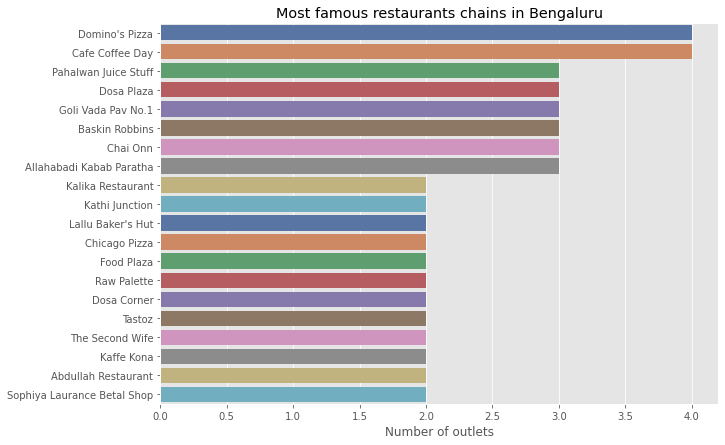

In [80]:
plt.figure(figsize=(10,7))
chains=df['name'].value_counts()[:20]
sns.barplot(x=chains,y=chains.index,palette='deep')
plt.title("Most famous restaurants chains in Bengaluru")
plt.xlabel("Number of outlets")
plt.savefig(city_name+'/number_of_outlets.png')
fig_dat['number_of_outlets'] = {}
fig_dat['number_of_outlets']['title'] = "Most famous restaurants chains in Bengaluru"
fig_dat['number_of_outlets']['long_text'] = "Histogram displaying most famous restaurants chains in Bengaluru"

In [81]:
x=df['online_order'].value_counts()
colors = ['#FEBFB3', '#E1396C']

trace=go.Pie(labels=x.index,values=x,textinfo="value",
            marker=dict(colors=colors, 
                           line=dict(color='#000000', width=2)))
layout=go.Layout(title="Accepting vs not accepting online orders",width=500,height=500)
fig=go.Figure(data=[trace],layout=layout)
fig.write_html("./accepting_vs_not_accepting_online_orders.html")
py.iplot(fig, filename='pie_chart_subplots')

In [82]:
import dash
import dash_core_components as dcc
import dash_html_components as html

app = dash.Dash()
app.layout = html.Div([
    dcc.Graph(figure=fig)
])

app.run_server(debug=True, use_reloader=False)

ModuleNotFoundError: ignored

In [83]:
x=df['book_table'].value_counts()
colors = ['#96D38C', '#D0F9B1']

trace=go.Pie(labels=x.index,values=x,textinfo="value",
            marker=dict(colors=colors, 
                           line=dict(color='#000000', width=2)))
layout=go.Layout(title="Table booking",width=500,height=500)
fig=go.Figure(data=[trace],layout=layout)
py.iplot(fig, filename='pie_chart_subplots')

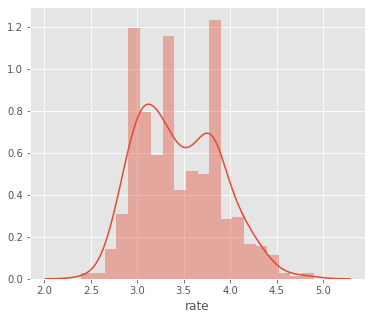

In [84]:
plt.figure(figsize=(6,5))
rating=df['rate'].dropna().apply(lambda x : float(x.split('/')[0]) if (len(x)>3)  else np.nan ).dropna()
sns.distplot(rating,bins=20)
plt.savefig(city_name+'/ratings_hist.png')
fig_dat['ratings_hist'] = {}
fig_dat['ratings_hist']['title'] = "Histogram of Ratings"
fig_dat['ratings_hist']['long_text'] = "Histogram of Ratings""Histogram displaying most famous restaurants chains in Bengaluru"

In [85]:
cost_dist=df[['rate','approx_cost(for two people)','online_order']].dropna()
cost_dist['rate']=cost_dist['rate'].apply(lambda x: float(x.split('/')[0]) if len(x)>3 else 0)
cost_dist['approx_cost(for two people)']=cost_dist['approx_cost(for two people)'].apply(lambda x: int(x.replace(',','')))

KeyError: ignored

In [86]:
plt.figure(figsize=(10,7))
sns.scatterplot(x="rate",y='approx_cost(for two people)',hue='online_order',data=cost_dist)
plt.show()
plt.savefig(city_name+'/approx_cost.png')

NameError: ignored

<Figure size 720x504 with 0 Axes>

In [87]:
plt.figure(figsize=(6,6))
sns.distplot(cost_dist['approx_cost(for two people)'])
plt.show()
plt.savefig(city_name+'/approx_cost_hist.png')

NameError: ignored

<Figure size 432x432 with 0 Axes>

In [88]:
votes_yes=df[df['online_order']=="Yes"]['votes']
trace0=go.Box(y=votes_yes,name="accepting online orders",
              marker = dict(
        color = 'rgb(214, 12, 140)',
    ))

votes_no=df[df['online_order']=="No"]['votes']
trace1=go.Box(y=votes_no,name="Not accepting online orders",
              marker = dict(
        color = 'rgb(0, 128, 128)',
    ))

layout = go.Layout(
    title = "Box Plots of votes",width=800,height=500
)

data=[trace0,trace1]
fig=go.Figure(data=data,layout=layout)
py.iplot(fig)

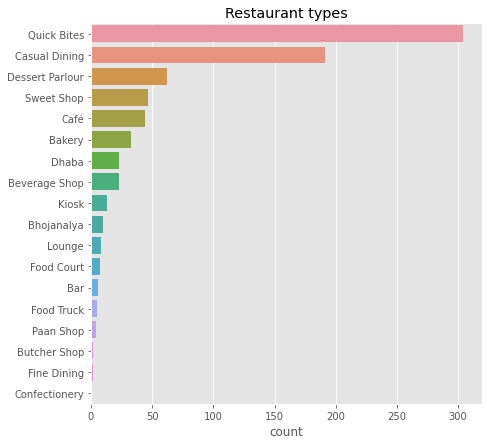

In [89]:
plt.figure(figsize=(7,7))
rest=df['rest_type'].value_counts()[:20]
sns.barplot(rest,rest.index)
plt.title("Restaurant types")
plt.xlabel("count")
plt.savefig('restaurant_types.png')
fig_dat['restaurant_types'] = {}
fig_dat['restaurant_types']['title'] = "Histogram of Ratings"
fig_dat['restaurant_types']['long_text'] = "Histogram of Ratings""Histogram displaying most famous restaurants chains in Bengaluru"

In [90]:
trace0=go.Box(y=df['approx_cost(for two people)'],name="accepting online orders",
              marker = dict(
        color = 'rgb(214, 12, 140)',
    ))
data=[trace0]
layout=go.Layout(title="Box plot of approximate cost",width=800,height=500,yaxis=dict(title="Price"))
fig=go.Figure(data=data,layout=layout)
py.iplot(fig)

KeyError: ignored

In [39]:
cost_dist=df[['rate','approx_cost(for two people)','location','name','rest_type']].dropna()
cost_dist['rate']=cost_dist['rate'].apply(lambda x: float(x.split('/')[0]) if len(x)>3 else 0)
cost_dist['approx_cost(for two people)']=cost_dist['approx_cost(for two people)'].apply(lambda x: int(x.replace(',','')))

KeyError: ignored

**Function to suggest best restaurant based on location, type of restaurant and cost of meal for two people**

In [0]:
def return_budget(location,rest, cost_for_two):
    budget=cost_dist[(cost_dist['approx_cost(for two people)']<=400) & (cost_dist['location']==location) & 
                     (cost_dist['rate']>4) & (cost_dist['rest_type']==rest)]
    return(budget['name'].unique())

In [41]:
return_budget('BTM',"Quick Bites", 400)

NameError: ignored

**Food Hotspots**

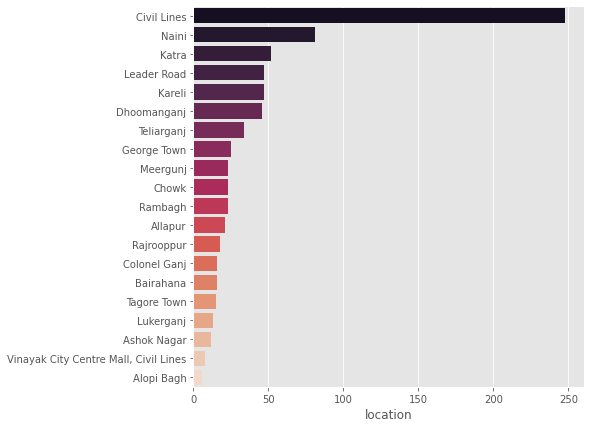

In [91]:
plt.figure(figsize=(7,7))
Rest_locations=df['location'].value_counts()[:20]
sns.barplot(Rest_locations,Rest_locations.index,palette="rocket")
plt.savefig(city_name+'/location_hist.png')
fig_dat['location_hist'] = {}
fig_dat['location_hist']['title'] = "Histogram of Ratings"
fig_dat['location_hist']['long_text'] = "Histogram of Ratings""Histogram displaying most famous restaurants chains in Bengaluru"

**Top 3 cuisines in each location**

In [0]:
df_1=df.groupby(['location','cuisines']).agg('count')
data=df_1.sort_values(['url'],ascending=False).groupby(['location'],
                as_index=False).apply(lambda x : x.sort_values(by="url",ascending=False).head(3))['url'].reset_index().rename(columns={'url':'count'})

In [93]:
data.head(10)

level_0     location                                        cuisines  count
0        0      Allapur                                    North Indian      3
1        0      Allapur                                        Desserts      3
2        0      Allapur                                       Fast Food      3
3        1   Alopi Bagh                                        Desserts      1
4        1   Alopi Bagh               Street Food, South Indian, Mithai      1
5        1   Alopi Bagh                                    North Indian      1
6        2  Ashok Nagar  Beverages, Cafe, Sandwich, Fast Food, Desserts      2
7        2  Ashok Nagar                                    North Indian      2
8        2  Ashok Nagar                                            Paan      1
9        3    Bairahana                                          Mithai      4

**Extract location coordinates using Geopy**

In [94]:
locations=pd.DataFrame({"Name":df['location'].unique()})
locations['Name']=locations['Name'].apply(lambda x: "Bangalore " + str(x))
lat_lon=[]
geolocator=Nominatim(user_agent="app")
for ind in tqdm(range(locations['Name'].shape[0])):
    location = locations['Name'][ind]
    try:
      location = geolocator.geocode(location)
    except:
      location = None
    if location is None:
        lat_lon.append(np.nan)
    else:    
        geo=(location.latitude,location.longitude)
        lat_lon.append(geo)


locations['geo_loc']=lat_lon
locations.to_csv('locations.csv',index=False)

In [95]:
locations["Name"]=locations['Name'].apply(lambda x :  x.replace("Bangalore","")[1:])
locations.head()

Name                           geo_loc
0       Civil Lines                               NaN
1       George Town                               NaN
2       Tagore Town                               NaN
3  The Legend Hotel  (13.03464355, 77.64008204137542)
4          Meergunj                               NaN

**Heatmap of restaurant count in each location**

In [96]:
Rest_locations=pd.DataFrame(df['location'].value_counts().reset_index())
Rest_locations.columns=['Name','count']
Rest_locations=Rest_locations.merge(locations,on='Name',how="left").dropna()
Rest_locations['count'].max()

23

In [0]:
def generateBaseMap(default_location=[12.97, 77.59], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [98]:
lat,lon=zip(*np.array(Rest_locations['geo_loc']))
Rest_locations['lat']=lat
Rest_locations['lon']=lon
basemap=generateBaseMap()
HeatMap(Rest_locations[['lat','lon','count']].values.tolist(),max_zoom=20,radius=15).add_to(basemap)

In [99]:
basemap

**Popular Cusinies in the city**

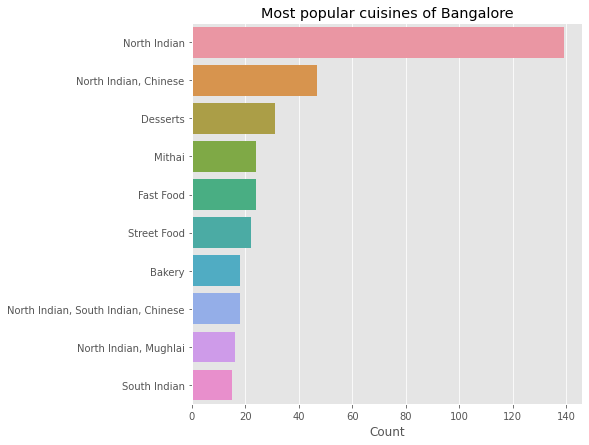

In [100]:
plt.figure(figsize=(7,7))
cuisines=df['cuisines'].value_counts()[:10]
sns.barplot(cuisines,cuisines.index)
plt.xlabel('Count')
plt.title("Most popular cuisines of Bangalore")
plt.savefig(city_name+'/most_popular_cuisines_hist.png')
fig_dat['most_popular_cuisines_hist'] = {}
fig_dat['most_popular_cuisines_hist']['title'] = "Histogram of Ratings"
fig_dat['most_popular_cuisines_hist']['long_text'] = "Histogram of Ratings""Histogram displaying most famous restaurants chains in Bengaluru"

**Heatmap of North Indian Restaurants**

In [0]:
def produce_data(col,name):
    data= pd.DataFrame(df[df[col]==name].groupby(['location'],as_index=False)['url'].agg('count'))
    data.columns=['Name','count']
    print(data.head())
    data=data.merge(locations,on="Name",how='left').dropna()
    data['lan'],data['lon']=zip(*data['geo_loc'].values)
    return data.drop(['geo_loc'],axis=1)

In [53]:
North_India=produce_data('cuisines','North Indian')

          Name  count
0      Allapur      3
1   Alopi Bagh      1
2  Ashok Nagar      2
3    Bairahana      2
4        Chowk      5


In [54]:
basemap=generateBaseMap()
HeatMap(North_India[['lan','lon','count']].values.tolist(),max_zoom=20,radius=15).add_to(basemap)
basemap

**Heatmap of South Indian Restaurants**

In [55]:
food=produce_data('cuisines','South Indian')
basemap=generateBaseMap()
HeatMap(food[['lan','lon','count']].values.tolist(),max_zoom=20,radius=15).add_to(basemap)
basemap

          Name  count
0      Allapur      1
1        Chowk      1
2  Civil Lines      2
3  George Town      2
4       Kareli      1


**Analysing Restaurant chains**

In [0]:
def produce_chains(name):
    data_chain=pd.DataFrame(df[df["name"]==name]['location'].value_counts().reset_index())
    data_chain.columns=['Name','count']
    data_chain=data_chain.merge(locations,on="Name",how="left").dropna()
    data_chain['lan'],data_chain['lon']=zip(*data_chain['geo_loc'].values)
    return data_chain[['Name','count','lan','lon']]

In [0]:
df_1=df.groupby(['rest_type','name']).agg('count')
datas=df_1.sort_values(['url'],ascending=False).groupby(['rest_type'],
                as_index=False).apply(lambda x : x.sort_values(by="url",ascending=False).head(3))['url'].reset_index().rename(columns={'url':'count'})

In [0]:
mapbox_access_token="pk.eyJ1Ijoic2hhaHVsZXMiLCJhIjoiY2p4ZTE5NGloMDc2YjNyczBhcDBnZnA5aCJ9.psBECQ2nub0o25PgHcU88w"

Enter the type of restaurant in the next cell

In [59]:
type_ = 'Casual Dining'

casual=datas[datas['rest_type']==type_]
casual

level_0      rest_type                     name  count
17        6  Casual Dining          The Second Wife      2
18        6  Casual Dining               Dosa Plaza      2
19        6  Casual Dining  Shahi Darbar Restaurant      1

In [0]:
def produce_trace(data_chain,name):
        data_chain['text']=data_chain['Name']+'<br>'+data_chain['count'].astype(str)
        trace =  go.Scattermapbox(
           
                lat=data_chain['lan'],
                lon=data_chain['lon'],
                mode='markers',
                marker=go.scattermapbox.Marker(
                    size=data_chain['count']*4
                ),
                text=data_chain['text'],name=name
            )
        
        return trace

In [61]:
data=[] 
for row in casual['name']:
    data_chain=produce_chains(row) 
    trace_0=produce_trace(data_chain,row)
    data.append(trace_0)



layout = go.Layout(title="Casual Dining Restaurant chains locations around Banglore",
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,style="streets",
        center=dict(
            lat=12.96,
            lon=77.59
        ),
        pitch=0,
        zoom=10
    ),
)


fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Montreal Mapbox')

ValueError: ignored

**Word Cloud of liked dishes**

In [0]:
df['dish_liked'].head()

0    Pasta, Lunch Buffet, Masala Papad, Paneer Laja...
1    Momos, Lunch Buffet, Chocolate Nirvana, Thai G...
2    Churros, Cannelloni, Minestrone Soup, Hot Choc...
3                                          Masala Dosa
4                                  Panipuri, Gol Gappe
Name: dish_liked, dtype: object

In [0]:
df['dish_liked']=df['dish_liked'].apply(lambda x : x.split(',') if type(x)==str else [''])

ValueError: ignored

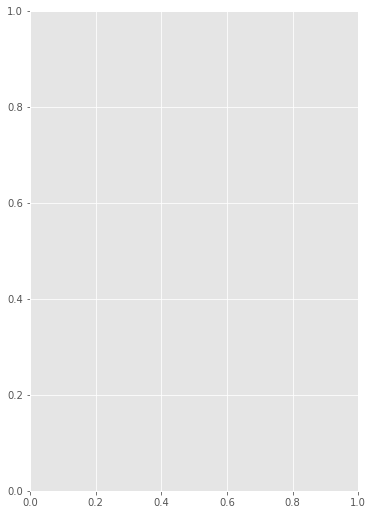

In [63]:
rest=df['rest_type'].value_counts()[:9].index
def produce_wordcloud(rest):
    
    plt.figure(figsize=(20,30))
    for i,r in enumerate(rest):
        plt.subplot(3,3,i+1)
        corpus=df[df['rest_type']==r]['dish_liked'].values.tolist()
        corpus=','.join(x  for list_words in corpus for x in list_words)
        wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1500, height=1500).generate(corpus)
        plt.imshow(wordcloud)
        plt.title(r)
        plt.axis("off")
      
produce_wordcloud(rest)

**Analysing Reviews**

In [64]:
all_ratings = []

for name,ratings in tqdm(zip(df['name'],df['reviews_list'])):
    ratings = eval(ratings)
    for score, doc in ratings:
        if score:
            score = score.strip("Rated").strip()
            doc = doc.strip('RATED').strip()
            score = float(score)
            all_ratings.append([name,score, doc])

KeyError: ignored

In [0]:
rating_df=pd.DataFrame(all_ratings,columns=['name','rating','review'])
rating_df['review']=rating_df['review'].apply(lambda x : re.sub('[^a-zA-Z0-9\s]',"",x))

In [0]:
rating_df.to_csv("Ratings.csv")

In [67]:
rating_df.head()

Empty DataFrame
Columns: [name, rating, review]
Index: []

**WordCloud of Reviews of restaurant chains**

ValueError: ignored

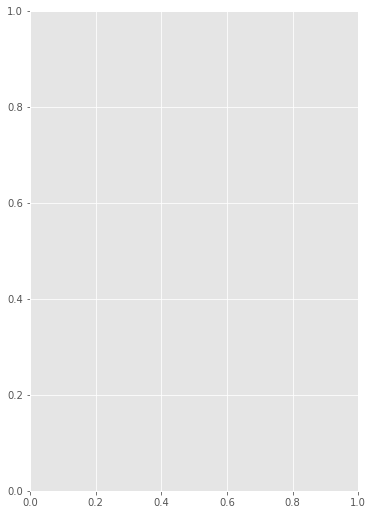

In [68]:
rest=df['name'].value_counts()[:9].index
def produce_wordcloud(rest):
    
    plt.figure(figsize=(20,30))
    for i,r in enumerate(rest):
        plt.subplot(3,3,i+1)
        corpus=rating_df[rating_df['name']==r]['review'].values.tolist()
        corpus=' '.join(x  for x in corpus)
        wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1500, height=1500).generate(corpus)
        plt.imshow(wordcloud)
        plt.title(r)
        plt.axis("off")
        

        
        
produce_wordcloud(rest)

**Rating Distribution**

In [69]:
plt.figure(figsize=(7,6))
rating=rating_df['rating'].value_counts()
sns.barplot(x=rating.index,y=rating)
plt.xlabel("Ratings")
plt.ylabel('count')
plt.savefig(city_name+'/ratings_hist.png')
fig_dat['ratings_hist'] = {}
fig_dat['ratings_hist']['title'] = "Histogram of Ratings"
fig_dat['ratings_hist']['long_text'] = "Histogram of Ratings""Histogram displaying most famous restaurants chains in Bengaluru"

ValueError: ignored

<Figure size 504x432 with 0 Axes>

In [0]:
rating_df['sent']=rating_df['rating'].apply(lambda x: 1 if int(x)>2.5 else 0)

# NLP Part: Text Processing

**Analysing Positive comments: rating>=2.5**

In [0]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
stops=stopwords.words('english')
lem=WordNetLemmatizer()
corpus=' '.join(lem.lemmatize(x) for x in rating_df[rating_df['sent']==1]['review'][:3000] if x not in stops)
tokens=word_tokenize(corpus)

In [0]:
vect=TfidfVectorizer()
vect_fit=vect.fit(tokens)

In [0]:
id_map=dict((v,k) for k,v in vect.vocabulary_.items())
vectorized_data=vect_fit.transform(tokens)
gensim_corpus=gensim.matutils.Sparse2Corpus(vectorized_data,documents_columns=False)
ldamodel = gensim.models.ldamodel.LdaModel(gensim_corpus,id2word=id_map,num_topics=5,random_state=34,passes=25)

In [0]:
counter=Counter(corpus)

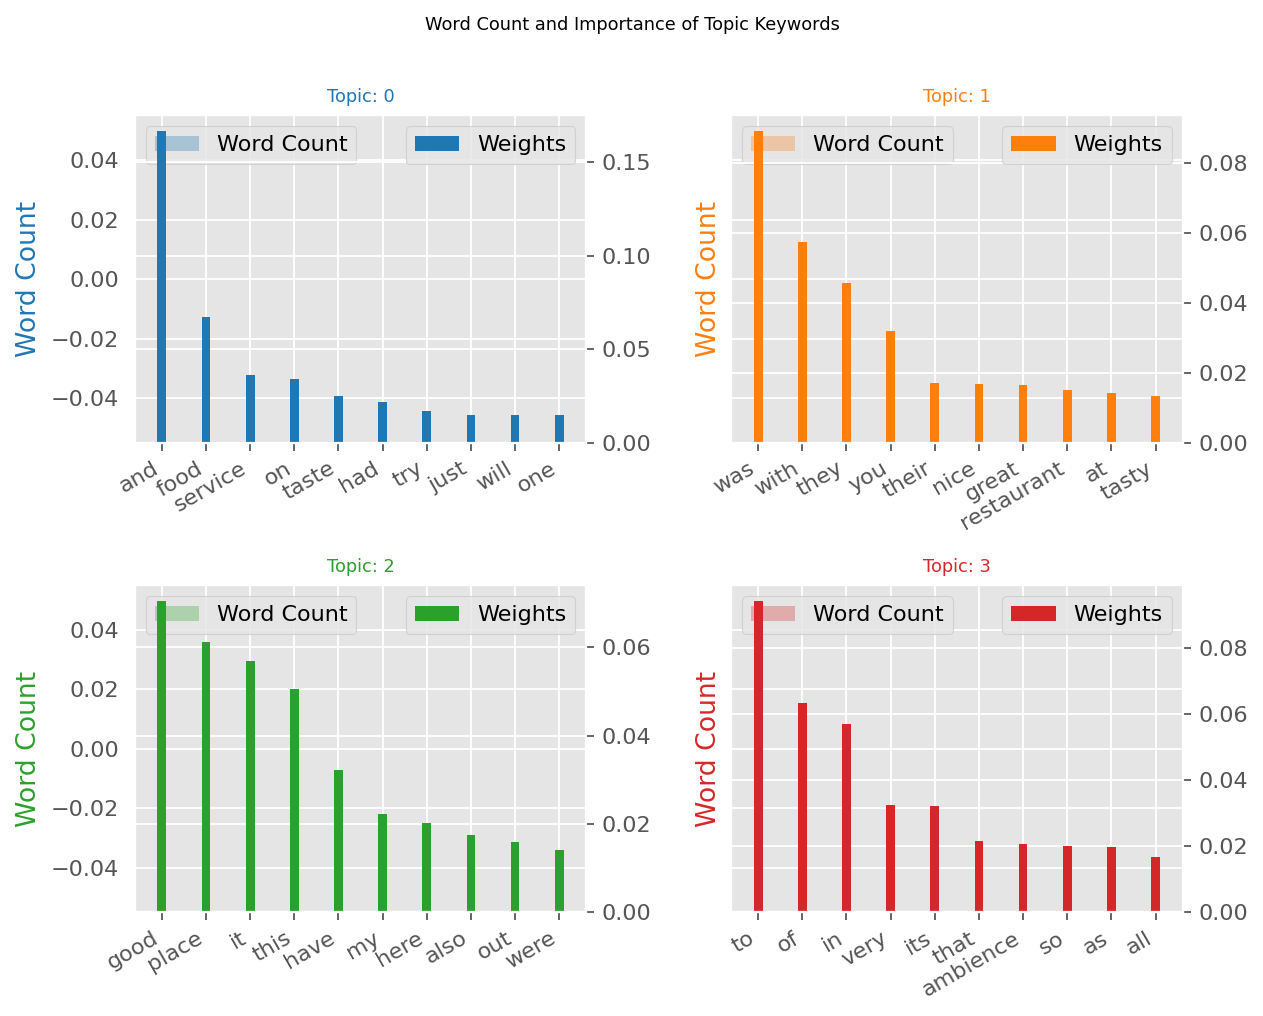

In [0]:
out=[]
topics=ldamodel.show_topics(formatted=False)
for i,topic in topics:
    for word,weight in topic:
        out.append([word,i,weight,counter[word]])

dataframe = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        


# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(8,6), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=dataframe.loc[dataframe.topic_id==i, :], color=cols[i], width=0.3, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=dataframe.loc[dataframe.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    #ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=8)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(dataframe.loc[dataframe.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=8, y=1.05)    
plt.show()
plt.savefig(city_name+'/word_count_and_topic.png')
fig_dat['word_count_and_topic'] = {}
fig_dat['word_count_and_topic']['title'] = "Histogram of Ratings"
fig_dat['word_count_and_topic']['long_text'] = "Histogram of Ratings""Histogram displaying most famous restaurants chains in Bengaluru"

**Analysing negative reviews: rating < 2.5**

In [0]:
stops=stopwords.words('english')
lem=WordNetLemmatizer()
corpus=' '.join(lem.lemmatize(x) for x in rating_df[rating_df['sent']==0]['review'][:3000] if x not in stops)
tokens=word_tokenize(corpus)

In [0]:
vect=TfidfVectorizer()
vect_fit=vect.fit(tokens)
id_map=dict((v,k) for k,v in vect.vocabulary_.items())
vectorized_data=vect_fit.transform(tokens)
gensim_corpus=gensim.matutils.Sparse2Corpus(vectorized_data,documents_columns=False)
ldamodel = gensim.models.ldamodel.LdaModel(gensim_corpus,id2word=id_map,num_topics=5,random_state=34,passes=25)

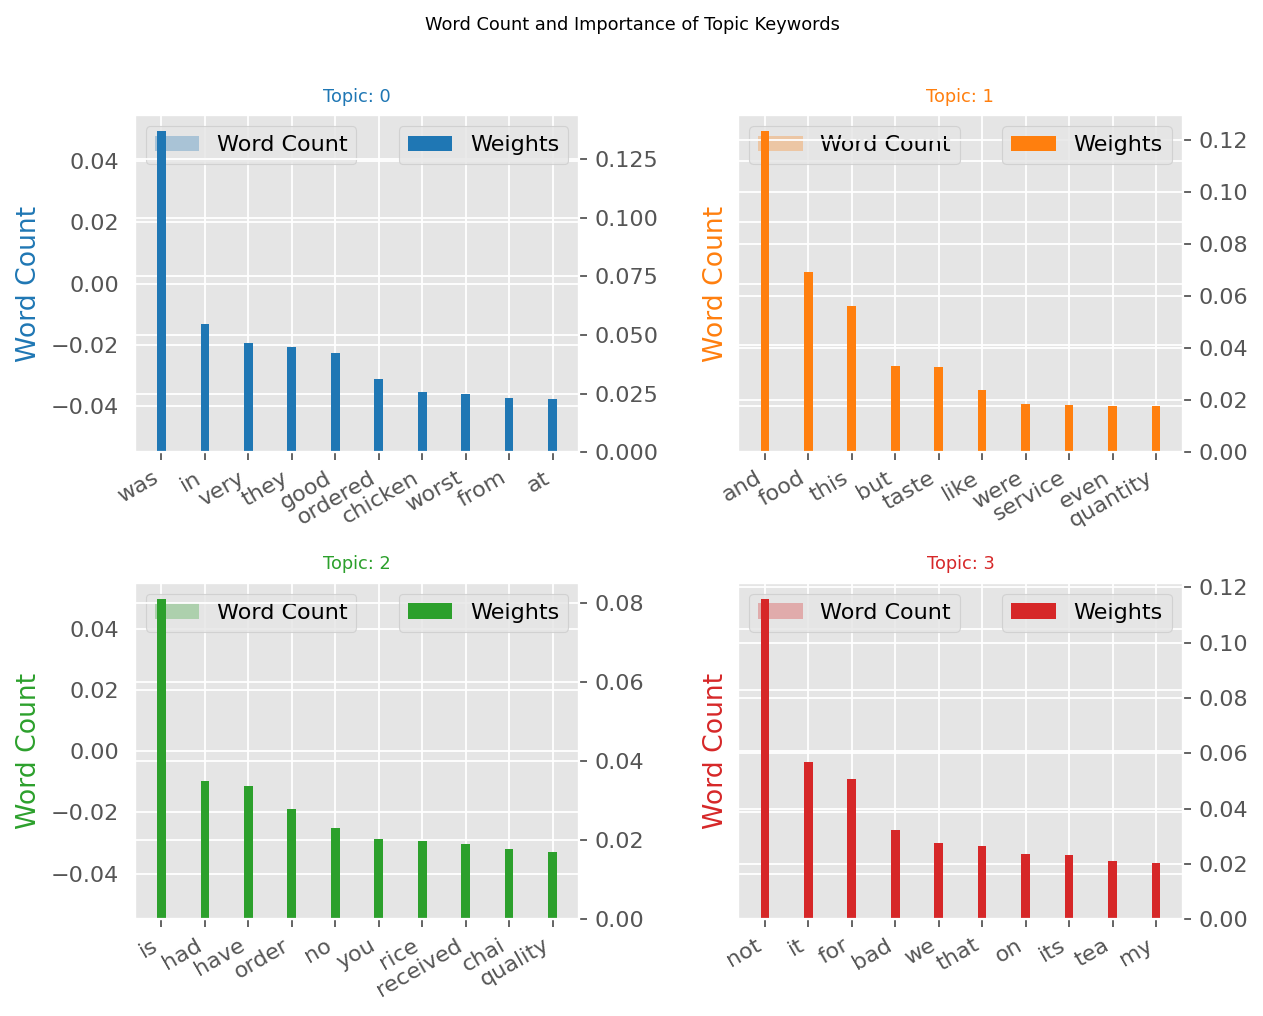

In [0]:
counter=Counter(corpus)
out=[]
topics=ldamodel.show_topics(formatted=False)
for i,topic in topics:
    for word,weight in topic:
        out.append([word,i,weight,counter[word]])

dataframe = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        


# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(8,6), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=dataframe.loc[dataframe.topic_id==i, :], color=cols[i], width=0.3, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=dataframe.loc[dataframe.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    #ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=8)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(dataframe.loc[dataframe.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=8, y=1.05)    
plt.show()
plt.savefig(city_name+'/word_count_and_topic2.png')
fig_dat['word_count_and_topic2'] = {}
fig_dat['word_count_and_topic2']['title'] = "Histogram of Ratings"
fig_dat['word_count_and_topic2']['long_text'] = "Histogram of Ratings""Histogram displaying most famous restaurants chains in Bengaluru"


*   We can clearly observe the difference between the two types of comments
*   The words used are clearly distinguishable.
*   The words used in negative comments are clearly critisizing.
*   The word used in positive comments are clearly appreciating.






**Visualising Word Space using tSNE**

In [0]:
stops=set(stopwords.words('english'))
lem=WordNetLemmatizer()
corpus=[]
for review in tqdm(rating_df['review'][:10000]):
    words=[]
    for x in word_tokenize(review):
        x=lem.lemmatize(x.lower())
        if x not in stops:
            words.append(x)
            
    corpus.append(words)

In [0]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)

In [0]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    plt.savefig(city_name+'/word_scatter.png')
    fig_dat['word_scatter'] = {}
    fig_dat['word_scatter']['title'] = "Histogram of Ratings"
    fig_dat['word_scatter']['long_text'] = "Histogram of Ratings""Histogram displaying most famous restaurants chains in Bengaluru"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



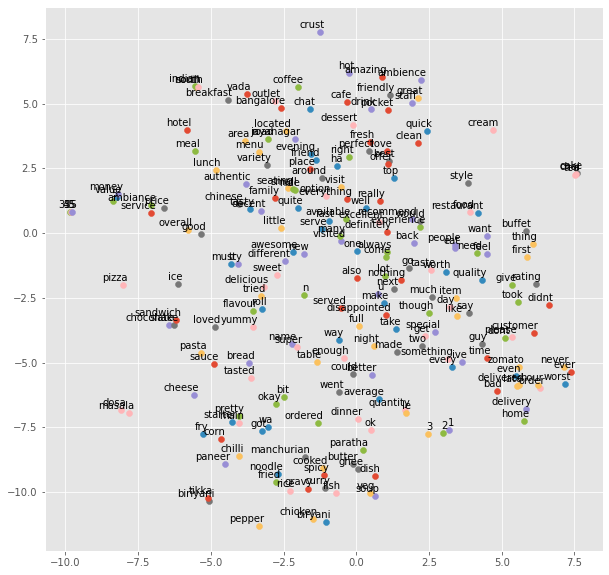

In [0]:
tsne_plot(model)

**tSNE of adjectives used in positive reviews**

In [0]:
postive=rating_df[rating_df['rating']>3]['review'][:2000]
negative=rating_df[rating_df['rating']<2.5]['review'][:2000]

def return_corpus(df):
    corpus=[]
    for review in df:
        tagged=nltk.pos_tag(word_tokenize(review))
        adj=[]
        for x in tagged:
            if x[1]=='JJ':
                adj.append(x[0])
        corpus.append(adj)
    return corpus

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



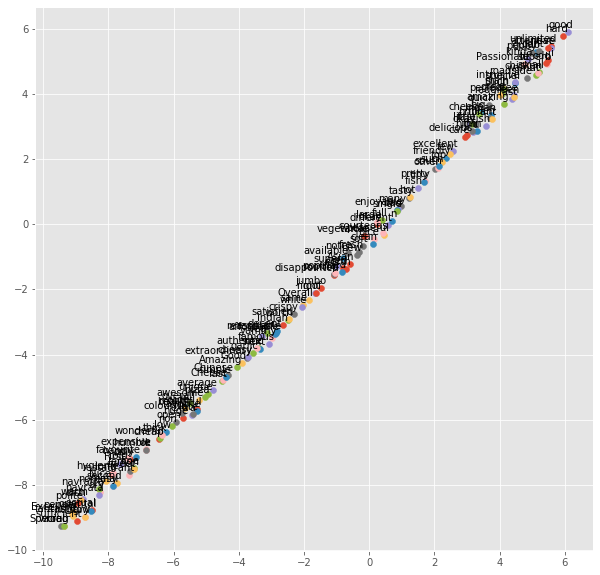

In [0]:
nltk.download('averaged_perceptron_tagger')

corpus=return_corpus(postive)
model = word2vec.Word2Vec(corpus, size=100, min_count=10,window=20, workers=4)
tsne_plot(model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



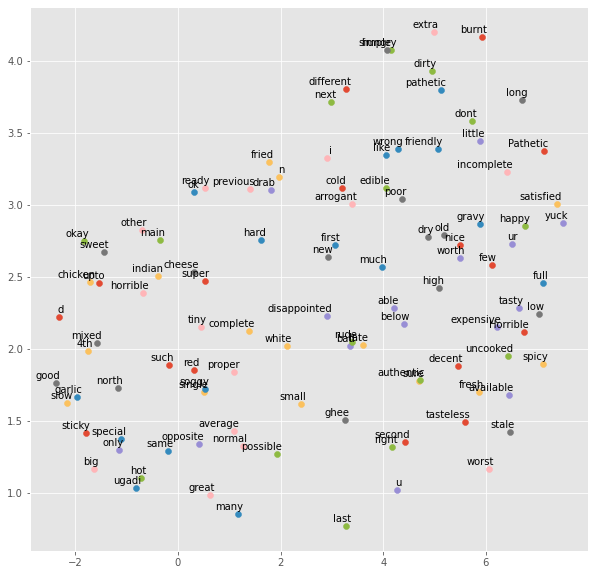

In [0]:
corpus=return_corpus(negative)
model = word2vec.Word2Vec(corpus, size=100, min_count=10,window=20, workers=4)
tsne_plot(model)

# NLP Part: Sentiment Analysis

In [0]:
rating_df['sent']=rating_df['rating'].apply(lambda x: 1 if int(x)>2.5 else 0)

In [0]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(rating_df['review'].values)
X = tokenizer.texts_to_sequences(rating_df['review'].values)
X = pad_sequences(X)

In [0]:
embed_dim = 32
lstm_out = 32

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
#model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 194, 32)           96000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 104,386
Trainable params: 104,386
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
Y = pd.get_dummies(rating_df['sent'].astype(int)).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(884378, 194) (884378, 2)
(435590, 194) (435590, 2)


In [0]:
batch_size = 3200
model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Epoch 1/5
884378/884378 [==============================] - 160s 181us/step - loss: 0.2628 - accuracy: 0.8959
Epoch 2/5
884378/884378 [==============================] - 157s 177us/step - loss: 0.1575 - accuracy: 0.9395
Epoch 3/5
884378/884378 [==============================] - 157s 178us/step - loss: 0.1405 - accuracy: 0.9467
Epoch 4/5
884378/884378 [==============================] - 158s 179us/step - loss: 0.1292 - accuracy: 0.9517
Epoch 5/5
884378/884378 [==============================] - 157s 178us/step - loss: 0.1209 - accuracy: 0.9553


In [0]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.12
acc: 0.96


## Creating Data Jason

In [0]:
import os


In [0]:
data = {'count': len(df), 'data':{}}

In [0]:

for root, dirs, files in os.walk(city_name, topdown=False):
    for file in files:
        if '.png' in file:
            data['data'][fig_dat[file[:-4]]['title']] = {}
            data['data'][fig_dat[file[:-4]]['title']]['longtext'] = fig_dat[file[:-4]]['long_text']
            data['data'][fig_dat[file[:-4]]['title']]['path'] = city_name+'/'+file
            data['data'][fig_dat[file[:-4]]['title']]['name'] = fig_dat[file[:-4]]['title']

In [112]:
data

{'count': 785,
 'data': {'Histogram of Ratings': {'longtext': 'Histogram of RatingsHistogram displaying most famous restaurants chains in Bengaluru',
   'name': 'Histogram of Ratings',
   'path': 'Allahabad/most_popular_cuisines_hist.png'},
  'Most famous restaurants chains in Bengaluru': {'longtext': 'Histogram displaying most famous restaurants chains in Bengaluru',
   'name': 'Most famous restaurants chains in Bengaluru',
   'path': 'Allahabad/number_of_outlets.png'}}}

In [0]:
import json

In [0]:
with open(city_name+'/data.json', 'w') as fp:
    json.dump(data, fp)

In [0]:
import os
import sys
 
pid = os.fork()
 
if pid > 0:
    print("This is written by the parent process")
else:
    os.execl(sys.executable, 'python3', "hello.py", *sys.argv[1:])
    os._exit(0)